<h1> Exercícios Resolvidos ICD - Aula 7 </h1>

Edesio Alcobaça (edesio@usp.br)<br>


MBA em Ciência de Dados <br>
Universidade de São Paulo, São Carlos, Brasil<br>
Copyright (c) 2021

### Exercícios de fixação

Não é necessário entregar os exercícios abaixo, mas é importante resolvê-los para fixar os conteúdos estudados.

1 - Repita todos os passos acima para a base de dados BreastCancer.

2 - Considerando a base de dados Vehicle, calcule as métricas de avaliação vistas nessa aula para os classificadores árvores de decisão e florestas aleatórias.

3 - Faça a classificação dos dados gerados artificialmente com o código abaixo. Compare os resultados para os métodos vistos nessa aula.

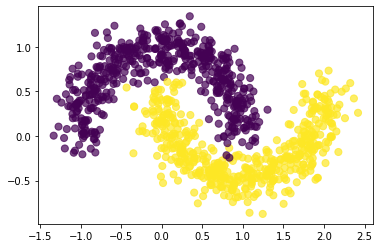

In [1]:
import matplotlib.pyplot as plt
from sklearn import datasets

plt.figure(figsize=(6,4))

n_samples = 1000

data  = datasets.make_moons(n_samples=n_samples, noise=.15, random_state=42)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)

<h2> Decision Tree (DT) </h2>

<img src="img/dt_dataset.png" width="400">

<img src="img/dt_pred.png" width="800">

<img src="img/dt_tree.png" width="400">
<center>Problema binário com dois atributos. Fonte: slide da aula prof. Francisco.</center>

<h2> Random Forest (RF) </h2>

<img src="img/random_forest_example.png" width="500">
<center>Exemplo do RF. Fonte: slide da aula prof. Francisco.</center>

<img src="img/random_forest_pred.png" width="800">
<center>Como funciona a classificação e regressão no RF. Fonte: <a href="https://towardsdatascience.com/random-forest-explained-7eae084f3ebe">z_ai</a>.</center>

<h2> 1) Repita todos os passos acima para a base de dados BreastCancer. </h2>

Carregar bibliotecas necessárias para execução:

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from dtreeviz.trees import dtreeviz

Ler conjunto de dados e estudá-lo:

In [3]:
data = pd.read_csv("data/BreastCancer.csv", header=(0))
data["Class"] = data["Class"].astype("category")

lin, col = data.shape
print(f"Number of features: {col-1}")
print(f"Number of examples: {lin}")

Number of features: 10
Number of examples: 699


In [4]:
# olhar os 10 primeiros exemplos
# data[data.columns[5]].plot.hist()
data.head(10)

,Id,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0
5,1017122,8,10,10,8,7,10.0,9,7,1,1
6,1018099,1,1,1,1,2,10.0,3,1,1,0
7,1018561,2,1,2,1,2,1.0,3,1,1,0
8,1033078,2,1,1,1,2,1.0,1,1,5,0
9,1033078,4,2,1,1,2,1.0,2,1,1,0


In [5]:
# verificar se existem NaN
data.isnull().values.any()

True

Vamos remover a coluna ID e remover exemplos com NaN:

In [6]:
data = data.dropna(axis="rows") # remove NaN
data = data.drop("Id", axis=1) # remove Id

lin, col = data.shape
print(f"Number of features: {col-1}")
print(f"Number of examples: {lin}")

Number of features: 9
Number of examples: 683


In [7]:
# descrever a coluna classe
data["Class"].describe()

count     683
unique      2
top         0
freq      444
Name: Class, dtype: int64

In [8]:
# frequência das classes
data["Class"].value_counts() / data.shape[0]

0    0.650073
1    0.349927
Name: Class, dtype: float64

In [9]:
# descrição do conjunto de dados
data.describe()

,Cl.thickness,Cell.size,Cell.shape,Marg.adhesion,Epith.c.size,Bare.nuclei,Bl.cromatin,Normal.nucleoli,Mitoses
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [10]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# sns.pairplot(data, hue="Class")

Após análise inicial dos dados, vamos dividi-los para então aplicar os algoritmos de AM:

In [11]:
features = data.drop("Class", axis=1)
target = data["Class"]

feature_names = features.columns.values
print(feature_names)
class_names = ["Healthy", "Sick"]
print(class_names)

X = features.values
y = target.values
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

['Cl.thickness' 'Cell.size' 'Cell.shape' 'Marg.adhesion' 'Epith.c.size'
 'Bare.nuclei' 'Bl.cromatin' 'Normal.nucleoli' 'Mitoses']
['Healthy', 'Sick']
(683, 9) (683,)
(546, 9) (546,)
(137, 9) (137,)


<h3> Classificação com Decision Tree (DT) </h3>

Para isso, podemos usar a classe <a href="https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html">DecisionTreeClassifier</a>, que gera modelos do algoritmo DT.

Observe que é necessário configurar os parâmetros que controlam o tamanho da árvore para evitar overfitting.
Além disso, perdemos o entendimento do modelo ao criar árvores muito compridas. Veja a nota na documentação do algoritmo:

<b>Notes</b>

<i>The default values for the parameters controlling the size of the trees (e.g. <mark>max_depth</mark>, <mark>min_samples_leaf</mark>, etc.) lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.</i>

Sem ajustar nada:

In [12]:
# cria um objeto que representa o algoritmo KNN
model = DecisionTreeClassifier(
    criterion="gini", # critério para medir a qualidade da divisão (split)
#     max_depth=4, # profundidade máxima da árvore
#     min_samples_leaf=0.005, # número mínimo de folhas em um nó
#     class_weight="balanced", # atribuir o mesmo peso para as duas classes
    random_state=42
 )

# Cria o "modelo" para o KNN com o método "fit"
# Aqui usamos os dados de treino para gerar o modelo
model.fit(
    X_train, # features/atributos de TREINO
    y_train # target/classe de TREINO
)

# faz a predição no conjunto com o método 'predict'
y_pred = model.predict(X_test)

acc = round(accuracy_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred, average="macro"), 2)
precision = round(precision_score(y_test, y_pred, average="macro"), 2)
recall = round(recall_score(y_test, y_pred, average="macro"), 2)

print(f"Accuracy: {acc}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.93
F1 score: 0.93
Precision: 0.94
Recall: 0.93


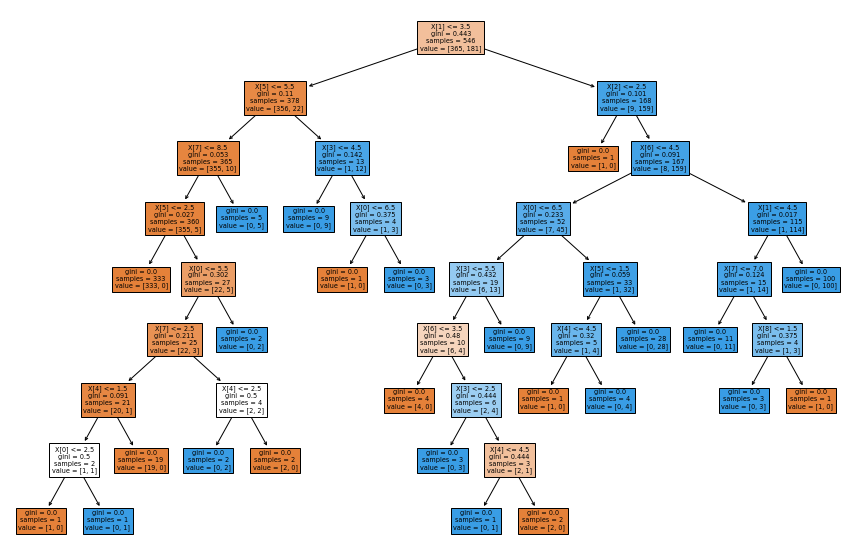

In [13]:
plt.figure(figsize=(15,10))
plot_tree(model.fit(X_train, y_train),filled=True)
plt.show(True)

Ajustando <mark>max_depth</mark> e <mark>min_samples_leaf</mark>:

In [14]:
# cria um objeto que representa o algoritmo KNN
model = DecisionTreeClassifier(
    criterion="gini", # critério para medir a qualidade da divisão (split)
    max_depth=4, # profundidade máxima da árvore
    min_samples_leaf=0.005, # número mínimo de folhas em um nó
#     class_weight="balanced", # atribuir o mesmo peso para as duas classes
    random_state=42
 )

# Cria o "modelo" para o KNN com o método "fit"
# Aqui usamos os dados de treino para gerar o modelo
model.fit(
    X_train, # features/atributos de TREINO
    y_train # target/classe de TREINO
)

# faz a predição no conjunto com o método 'predict'
y_pred = model.predict(X_test)

acc = round(accuracy_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred, average="macro"), 2)
precision = round(precision_score(y_test, y_pred, average="macro"), 2)
recall = round(recall_score(y_test, y_pred, average="macro"), 2)

print(f"Accuracy: {acc}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.94
F1 score: 0.94
Precision: 0.94
Recall: 0.94


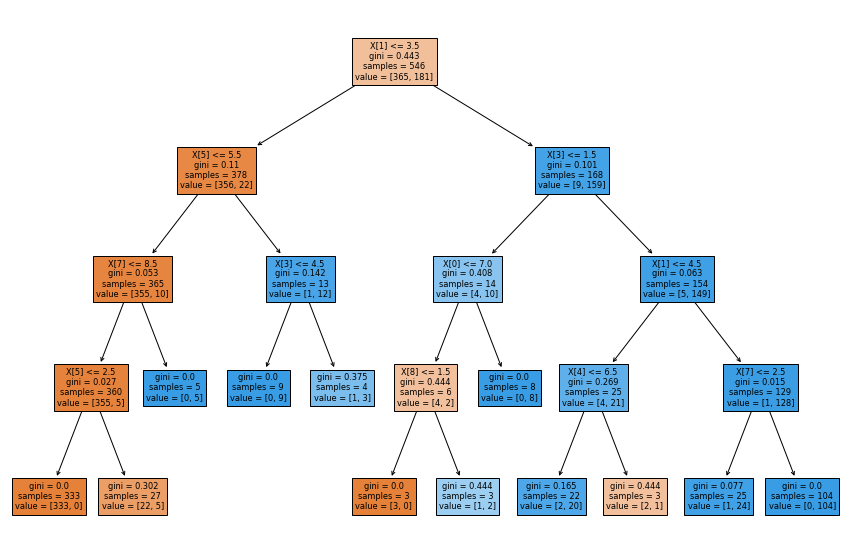

In [15]:
plt.figure(figsize=(15,10))
plot_tree(model.fit(X_train, y_train),filled=True)
plt.show(True)

Ajustando <mark>class_weight</mark> para atribuir mesmo peso as classes:

In [16]:
# cria um objeto que representa o algoritmo KNN
model = DecisionTreeClassifier(
    criterion="gini", # critério para medir a qualidade da divisão (split)
    max_depth=4, # profundidade máxima da árvore
    min_samples_leaf=0.005, # número mínimo de folhas em um nó
    class_weight="balanced", # atribuir o mesmo peso para as duas classes
    random_state=42
 )

# Cria o "modelo" para o KNN com o método "fit"
# Aqui usamos os dados de treino para gerar o modelo
model.fit(
    X_train, # features/atributos de TREINO
    y_train # target/classe de TREINO
)

# faz a predição no conjunto com o método 'predict'
y_pred = model.predict(X_test)

acc = round(accuracy_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred, average="macro"), 2)
precision = round(precision_score(y_test, y_pred, average="macro"), 2)
recall = round(recall_score(y_test, y_pred, average="macro"), 2)

print(f"Accuracy: {acc}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.95
F1 score: 0.95
Precision: 0.95
Recall: 0.95


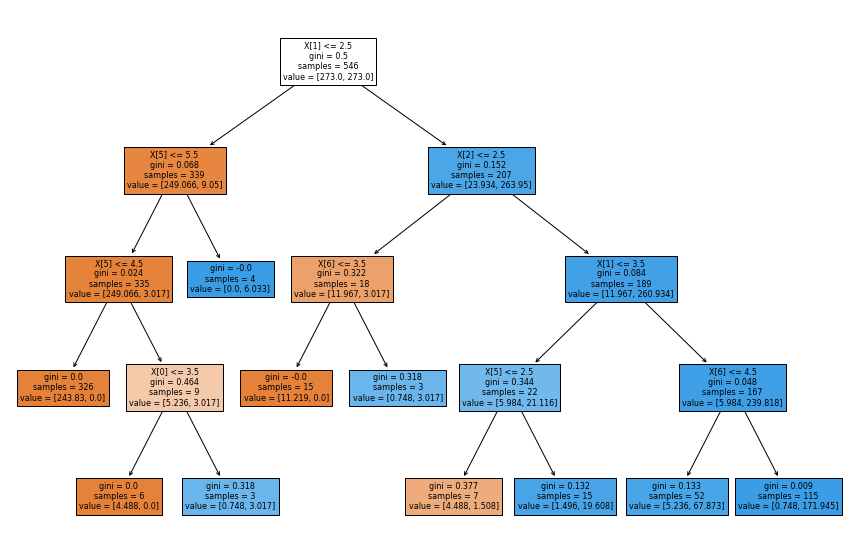

In [17]:
plt.figure(figsize=(15,10))
plot_tree(model.fit(X_train, y_train),filled=True)
plt.show(True)

Outra forma interessante de visualizar árvores é usando o dtreeviz

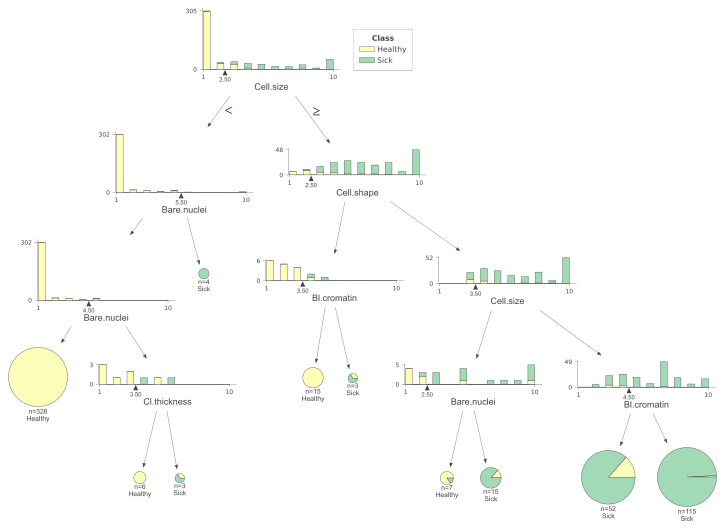

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

viz = dtreeviz(
    model, # modelo previamente treinado
    X_train, # conjunto de treino
    y_train, # target de treino
    target_name='Class', # nome do target
    feature_names=feature_names, # nomes das features/atributos
    class_names=class_names # nomes das classes
)  
              
# viz.view()
viz

Sick


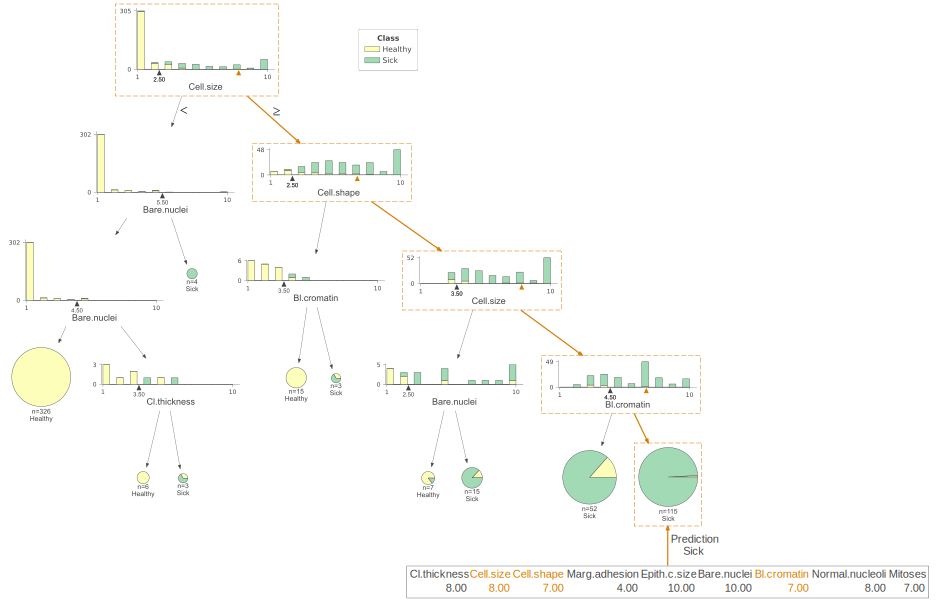

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

viz = dtreeviz(
    model, # modelo previamente treinado
    X_train, # conjunto de treino
    y_train, # target de treino
    target_name='Class', # nome do target
    feature_names=feature_names, # nomes das features/atributos
    class_names=class_names, # nomes das classes
#     orientation ='LR',  # orientacao da esquerda para direita
    X=X_test[1]
)
print(class_names[y_test[1]])
              
# viz.view()
viz

Vamos salvar os resultados do último experimento para depois fazermos comparações:

In [20]:
model_dt = model
y_test_dt = y_test
y_pred_dt = y_pred

Feature Importance:

De acordo com o sklearn:

<i>
The higher, the more important the feature. The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance.
</i>

1.0


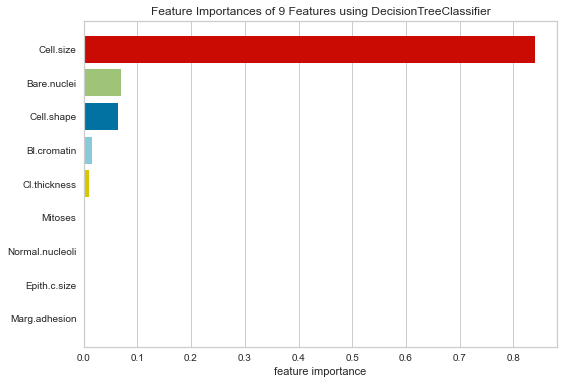

In [21]:
from yellowbrick.model_selection import feature_importances
print(np.sum(model_dt.feature_importances_))

feature_importances(
    model_dt,
    X_train,
    y_test,
    labels=feature_names,
    relative=False,
)
plt.show()

<h3> Classificação com Random Forest (RF) </h3>

Para isso, podemos usar a classe <a href="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html">RandomForestClassifier</a>, que gera modelos do algoritmo RF.

In [22]:
# cria um objeto que representa o algoritmo RF
model = RandomForestClassifier(
    n_estimators=100, # número de árvores
    criterion="gini", # critério para medir a qualidade da divisão (split)
    class_weight="balanced", # atribuir o mesmo peso para as duas classes
    random_state=42
)

# Cria o modelo para o RF com o método "fit"
# Aqui usamos os dados de treino para gerar o modelo
model.fit(
    X_train, # features/atributos de TREINO
    y_train # target/classe de TREINO
)

# faz a predição no conjunto com o método 'predict'
y_pred = model.predict(X_test)

acc = round(accuracy_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred, average="macro"), 2)
precision = round(precision_score(y_test, y_pred, average="macro"), 2)
recall = round(recall_score(y_test, y_pred, average="macro"), 2)

print(f"Accuracy: {acc}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.94
F1 score: 0.94
Precision: 0.95
Recall: 0.94


Vamos variar os valores de <mark>n_estimators</mark>:

In [23]:
folds = 10 # numero de folds
n_values = [] # armazena os valores de k
acc_train = []
acc_test = []
n_max = 200

for n in [1, 3, 5, 7, 10, 15, 25, 35, 45, 50, 75, 100]:
    # cria modelo
    model = RandomForestClassifier(
        n_estimators=n, # número de árvores
        criterion="gini", # critério para medir a qualidade da divisão (split)
        class_weight="balanced", # atribuir o mesmo peso para as duas classes
        random_state=42
    )
    
    # realiza a validação cruzada
    cv = cross_validate(model, X_train, y_train, cv=folds, return_train_score=True, n_jobs=4)
    # print(cv)
    #print('k:', k, 'accurace:', cv['test_score'].mean())
    acc_train.append(cv['train_score'].mean()) 
    acc_test.append(cv['test_score'].mean()) 
    n_values.append(n)

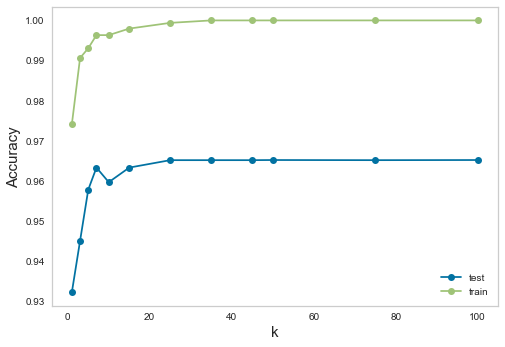

[  1   3   5  10   7  15  25  35  45  75  50 100]
[0.93228956 0.94508418 0.95784512 0.95969697 0.96333333 0.96333333
 0.96518519 0.96518519 0.96518519 0.96518519 0.96521886 0.96521886]
Best n is : 50


In [24]:
plt.plot(n_values, acc_test, "-o", label="test")
plt.plot(n_values, acc_train, "-o", label="train")
plt.xlabel("k", fontsize= 15)
plt.ylabel("Accuracy", fontsize= 15)
#plt.xticks(np.arange(1, n_max+1, 2))
plt.grid()
plt.legend(loc="best")
plt.show(True)

k_values = np.array(n_values)
acc_test = np.array(acc_test)
best_n = n_values[np.argmax(acc_test)]
print(k_values[np.argsort(acc_test)])
print(acc_test[np.argsort(acc_test)])
print('Best n is :', best_n)

Você pode plotar gráfico considerando um intervalo de confiança usando o seaborn:

In [25]:
folds = 10 # numero de folds
n_values = [] # armazena os valores de k
acc_train = []
acc_test = []

dic = {
    "acc": [],
    "train_test": [],
    "n_estimators": []
    
} 

for n in [1, 3, 5, 7, 10, 15, 25, 35, 45, 50, 75, 100]:
#for n in range(1, 100, 2):
    # cria modelo
    model = RandomForestClassifier(
        n_estimators=n, # número de árvores
        criterion="gini", # critério para medir a qualidade da divisão (split)
        class_weight="balanced", # atribuir o mesmo peso para as duas classes
        random_state=42
    )
    
    # realiza a validação cruzada
    cv = cross_validate(model, X_train, y_train, cv=folds, return_train_score=True, n_jobs=4)
    dic["acc"] += cv['train_score'].tolist() + cv['test_score'].tolist()
    dic["train_test"] += (["train_score"]*folds) + (['test_score']*folds)
    dic["n_estimators"] += [n]*2*folds

df = pd.DataFrame(dic)

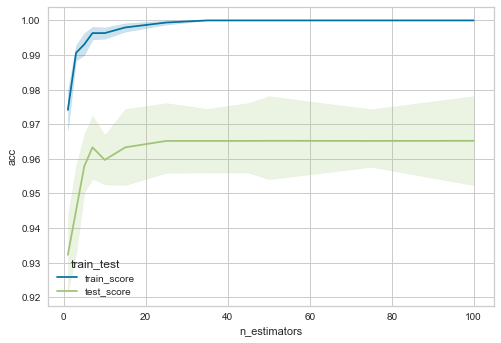

In [26]:
import seaborn as sns

sns.lineplot(
    data=df,
    x="n_estimators", y="acc", hue="train_test", 
    markers=True, dashes=False
)

plt.show()

In [27]:
# cria um objeto que representa o algoritmo RF
model = RandomForestClassifier(
    n_estimators=50, # número de árvores
    criterion="gini", # critério para medir a qualidade da divisão (split)
    class_weight="balanced", # atribuir o mesmo peso para as duas classes
    random_state=42
)

# Cria o modelo para o RF com o método "fit"
# Aqui usamos os dados de treino para gerar o modelo
model.fit(
    X_train, # features/atributos de TREINO
    y_train # target/classe de TREINO
)

# faz a predição no conjunto com o método 'predict'
y_pred = model.predict(X_test)

acc = round(accuracy_score(y_test, y_pred), 2)
f1 = round(f1_score(y_test, y_pred, average="macro"), 2)
precision = round(precision_score(y_test, y_pred, average="macro"), 2)
recall = round(recall_score(y_test, y_pred, average="macro"), 2)

print(f"Accuracy: {acc}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.96
F1 score: 0.95
Precision: 0.96
Recall: 0.95


Vamos salvar os resultados do último experimento para depois fazermos comparações:

In [28]:
model_rf = model
y_test_rf = y_test
y_pred_rf = y_pred

Feature Importance:

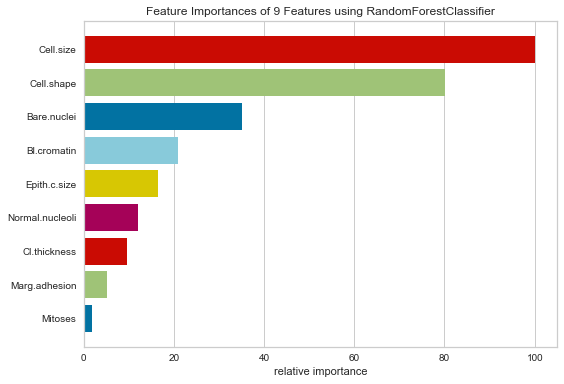

In [29]:
from yellowbrick.model_selection import feature_importances

feature_importances(
    model_rf,
    X_train,
    y_test,
    labels=feature_names,
)
plt.show()

<h3> Avaliação de Classificadores </h3>

<h4> Matrix de Confusão </h4>

<img src="img/conf_matrix.png" width="1000">
<center>Matrix de confusão. Fonte: <a href="https://en.wikipedia.org/wiki/Confusion_matrix">Wikipedia</a>.</center>

Você pode fazer isso usando a função <mark> confusion_matrix </mark>

In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_dt)
print(cm)

[[75  4]
 [ 3 55]]


In [31]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_dt).ravel()
print("TP: ", tp)
print("TN: ", tn)
print("FP: ", fp)
print("FN: ", fn)

TP:  55
TN:  75
FP:  4
FN:  3


In [32]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
print("TP: ", tp)
print("TN: ", tn)
print("FP: ", fp)
print("FN: ", fn)

TP:  53
TN:  78
FP:  1
FN:  5


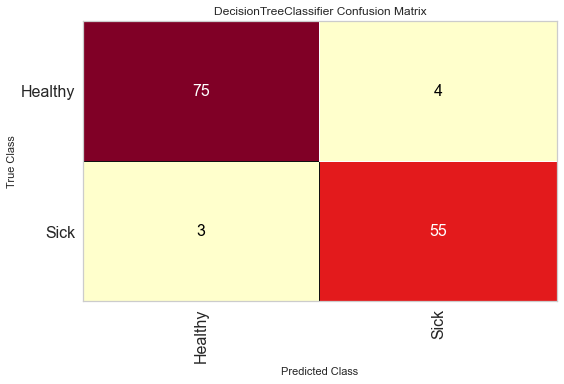

In [33]:
from yellowbrick.classifier import confusion_matrix

confusion_matrix(
    model_dt,
    X_train, y_train, X_test, y_test,
    classes=class_names,
#     percent=True,
    fontsize=16,
)

plt.show()

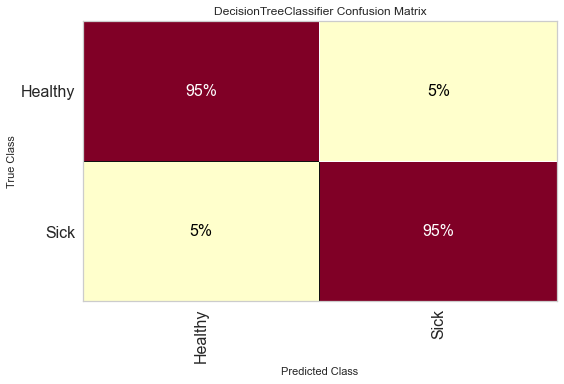

In [34]:
from yellowbrick.classifier import confusion_matrix

confusion_matrix(
    model_dt,
    X_train, y_train, X_test, y_test,
    classes=class_names,
    percent=True,
    fontsize=16,
)

plt.show()

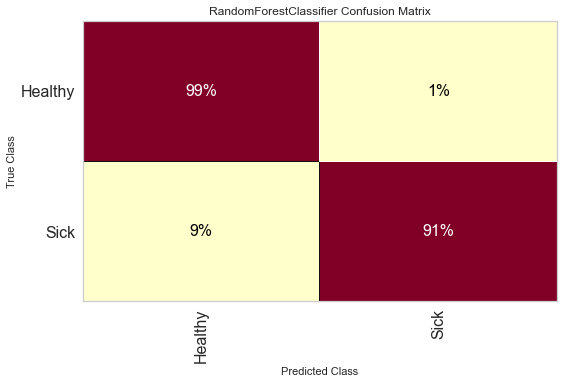

In [35]:
from yellowbrick.classifier import confusion_matrix

confusion_matrix(
    model_rf,
    X_train, y_train, X_test, y_test,
    classes=class_names,
    percent=True,
    fontsize=16,
)

plt.show()

<h4> Outras Métricas </h4>

Vamos estudar 4 diferentes métricas:
* accuracy
* f1
* precision
* recall

Lembre-se que as três últimas medidas são definidas apenas para problemas binários. Portanto para problemas multi-classe (onde temos mais de 3 classes) em geral usa-se a média de cada classe com ponderação dependendo do parâmetro <mark>average</mark>.


<b> Note: </b>

<i>In the multi-class and multi-label case, this is the average of the F1 score of each class with weighting depending on the <mark>average</mark> parameter. Font: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

* macro: média não ponderada (toda classe tem mesmo peso)

* weighted: média ponderada pela quantidade de exemplos em cada classe (peso dado pela quantidade de exemplos por classe)
    
</i>

Diferença entre macro e weighted: https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report

DT performance:

In [36]:
acc = round(accuracy_score(y_test, y_pred_dt), 3)
f1 = round(f1_score(y_test, y_pred_dt, average="macro"), 3)
precision = round(precision_score(y_test, y_pred_dt, average="macro"), 3)
recall = round(recall_score(y_test, y_pred_dt, average="macro"), 3)

print(f"Accuracy: {acc}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.949
F1 score: 0.948
Precision: 0.947
Recall: 0.949


In [37]:
print('\n clasification report:\n', classification_report(y_test, y_pred_dt, digits=3))


 clasification report:
               precision    recall  f1-score   support

           0      0.962     0.949     0.955        79
           1      0.932     0.948     0.940        58

    accuracy                          0.949       137
   macro avg      0.947     0.949     0.948       137
weighted avg      0.949     0.949     0.949       137



RF performance:

In [38]:
acc = round(accuracy_score(y_test, y_pred_rf), 3)
f1 = round(f1_score(y_test, y_pred_rf, average="macro"), 3)
precision = round(precision_score(y_test, y_pred_rf, average="macro"), 3)
recall = round(recall_score(y_test, y_pred_rf, average="macro"), 3)

print(f"Accuracy: {acc}")
print(f"F1 score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.956
F1 score: 0.955
Precision: 0.961
Recall: 0.951


In [39]:
print('\n clasification report:\n', classification_report(y_test, y_pred_rf, digits=3))


 clasification report:
               precision    recall  f1-score   support

           0      0.940     0.987     0.963        79
           1      0.981     0.914     0.946        58

    accuracy                          0.956       137
   macro avg      0.961     0.951     0.955       137
weighted avg      0.957     0.956     0.956       137



Observe que <mark>macro</mark> faz média simples, i.e., cada classe tem o mesmo peso:

In [40]:
round((0.987 + 0.914)/2, 3)

0.951

Já <mark>weighted</mark> faz média ponderada, i.e., cada classe tem pesos diferentes referente a quantidade de exemplos (favorece quem tem mais):

In [41]:
round((0.987*(79/137)) + (0.914*(58/137)), 3)

0.956

É possível usar também a AUC:

Veja mais detalhes neste post: https://towardsdatascience.com/an-understandable-guide-to-roc-curves-and-auc-and-why-and-when-to-use-them-92020bc4c5c1

<img src="img/roc_curve.png" width="600">
<center>Matrix de confusão. Fonte: <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic">Wikipedia</a>.</center>

Plot da curva ROC:

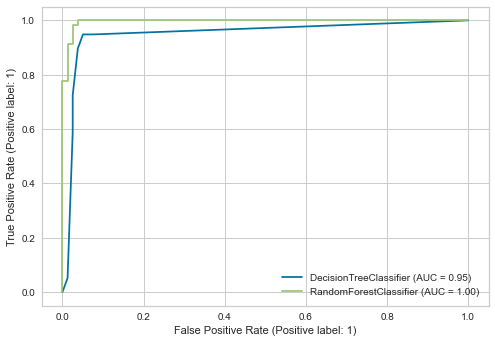

In [42]:
from sklearn import metrics

metrics.plot_roc_curve(model_dt, X_test, y_test)
#plt.show()

ax = plt.gca()
metrics.plot_roc_curve(model_rf, X_test, y_test, ax=ax)
plt.show()

Medindo a AUC:

In [43]:
from sklearn.metrics import roc_auc_score

auc_rf = roc_auc_score(y_test, model_rf.predict_proba(X_test)[:, 1])
auc_dt = roc_auc_score(y_test, model_dt.predict_proba(X_test)[:, 1])

print("AUC-RF: ", round(auc_rf, 3))
print("AUC-DT: ", round(auc_dt, 3))

AUC-RF:  0.996
AUC-DT:  0.95


Entendendo o thresholds e como ele pode nos beneficiar:

In [44]:
from sklearn.metrics import roc_curve

preds = model_dt.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds),columns = ["FPR","TPR","Threshold"])
roc_df

,FPR,TPR,Threshold
0,0.000000,0.000000,2.000000
1,0.012658,0.051724,1.000000
2,0.025316,0.586207,0.995669
3,0.025316,0.724138,0.929117
4,0.037975,0.896552,0.928386
5,0.050633,0.948276,0.801317
6,0.075949,0.948276,0.251551
7,1.000000,1.000000,0.000000


In [45]:
from sklearn.metrics import roc_curve

preds = model_rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, preds)
roc_df = pd.DataFrame(zip(fpr, tpr, thresholds), columns = ["FPR","TPR","Threshold"])
roc_df

,FPR,TPR,Threshold
0,0.000000,0.000000,2.00
1,0.000000,0.327586,1.00
2,0.000000,0.413793,0.98
3,0.000000,0.431034,0.96
4,0.000000,0.482759,0.94
5,0.000000,0.620690,0.90
6,0.000000,0.672414,0.82
7,0.000000,0.706897,0.80
8,0.000000,0.758621,0.78
9,0.000000,0.775862,0.76


In [46]:
print(preds)
y_test_thresholds = preds >= 0.22
print(recall_score(y_test, y_test_thresholds))

#print(accuracy_score(y_test, y_test_thresholds))

[0.86 1.   0.   0.   0.   0.   0.   0.02 0.58 0.   0.   0.   0.   0.
 0.22 1.   0.   0.76 0.   1.   1.   0.02 1.   0.   0.   0.   0.94 1.
 0.   0.9  0.   0.98 1.   0.4  0.   0.   1.   0.   0.88 0.78 0.   0.98
 1.   0.   0.   0.92 0.   0.8  0.   0.98 0.08 0.   0.   0.9  0.   0.94
 0.62 0.   0.   1.   0.   0.   0.   0.96 0.   0.   0.78 0.42 0.   0.04
 0.98 0.   0.   0.   1.   0.92 0.   0.   0.56 1.   0.94 0.9  0.12 1.
 0.   1.   0.   0.   1.   0.   0.   0.64 0.   0.62 0.   0.   0.56 0.74
 0.   0.3  0.   0.5  0.9  0.   0.66 0.34 0.   0.   1.   0.   0.92 1.
 0.78 0.02 0.   0.   0.8  0.   0.06 0.   0.66 1.   0.   0.   0.   0.06
 0.82 0.   0.32 0.02 0.   0.   0.92 1.   0.98 0.   0.  ]
1.0


<h2> 4) Extra: </h2>

<h3> Instalando as Bibliotecas dtreeviz e yellowbrick </h3>

Se você usa pip execute a seguinte célula:

!pip install dtreeviz yellowbrick

Veja mais informações em: https://github.com/parrt/dtreeviz e https://github.com/DistrictDataLabs/yellowbrick

<h2> How to visualize decision trees </h2>

* https://explained.ai/decision-tree-viz/index.html
* https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_sklearn_visualisations.ipynb
* https://github.com/parrt/dtreeviz